# Happywhale - Visualise False Classifications

In [1]:
# These library are for data manipulation 
import numpy as np
import pandas as pd

# These library are for working with directories
import os
from glob import glob
from tqdm import tqdm

# These library are for Visualization
import matplotlib.pyplot as plt
import plotly.express as px
from PIL import Image

# These library are for the Dataset
from sklearn.model_selection import train_test_split

# These Library are for converting Label Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# These library are for loading Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow import keras


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
path = 'C:/Users/sheri/Dev/'
path_traindata = path + 'whale_competition/csv/train.csv'
path_trainimages = path + 'whale_competition_datasets/yolo/train_images/'
path_model = path + 'whale_competition/Models/model.h5'
path_savecsv = path + 'whale_competition/csv/visualiseFalse.csv'

## Load Model, Predict & Get False Classfications

In [3]:
train_df = pd.read_csv(path_traindata)
# Removing duplicate values form the train_df of column individual_id
train_df = train_df.drop_duplicates(subset=['individual_id'],keep='last')

# Follow random_state in the train notebooks
train, val = train_test_split(train_df, test_size=0.2, random_state=42)

In [4]:
model = keras.models.load_model(path_model)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 27, 27, 32)        3488      
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 27, 27, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 activation_3 (Activation)   (None, 11, 11, 64)       

In [5]:
# Load images
def Loading_Images(data, m, dataset):
    print("Loading images")
    X_train = np.zeros((m, 32, 32, 3))
    count = 0
    for fig in tqdm(data['image']):
        img = image.load_img(dataset+fig, target_size=(32, 32, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        X_train[count] = x
        count += 1
    return X_train

# Convert text categories to numeric values
def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    y = onehot_encoded
    return y, label_encoder

In [6]:
# Preparing new df to write predictions into
val_df = val.copy(deep=True)
val_df.reset_index(drop=True, inplace=True)
val_df['prediction'] = ''
val_df.dropna(axis=0, inplace=True)

# Writing predictions into df
X = Loading_Images(val_df, val_df.shape[0], path_trainimages)
X /= 255
predictions = model.predict(np.array(X), verbose=1)
y, label_encoder = prepare_labels(train_df['individual_id'])

for i, pred in enumerate(predictions):
    p = pred.argsort()[-5:][::-1]
    for x in p:
        s = label_encoder.inverse_transform(p)[0]
    val_df.loc[i, 'prediction'] = s
    #print(val_df.iloc[i])

len_before = len(val_df)
val_df['correct'] = (val_df['individual_id'] == val_df['prediction'])
val_df.drop(val_df[val_df['correct'] == True].index, inplace=True)
len_after = len(val_df)
print("{} of {} individuals wrongly identified.".format(len_after, len_before))

print(val_df.head())
val_df.to_csv(path_savecsv)

Loading images


100%|██████████| 3118/3118 [00:01<00:00, 1578.73it/s]


98/98 [==============================] - 1s 7ms/step
35 of 3118 individuals wrongly identified.
                  image          species individual_id    prediction  correct
17   607a018d245cf3.jpg    dusky_dolphin  c5940154ce98  4930148c7db6    False
89   2b06e249409e18.jpg      pilot_whale  482247439879  af8bcea82736    False
159  b44a6f89519aca.jpg   humpback_whale  f0795c89a15c  4930148c7db6    False
181  e4e86aa454cdac.jpg     killer_whale  ac28317ce07c  a146a3719a99    False
269  8bd2e9889b20b3.jpg  spinner_dolphin  9fda5cdd0f98  4930148c7db6    False


## Data Visualisation of False Classifications

### Charts of the Species

In [7]:
val_df = pd.read_csv(path_savecsv)
fig = px.pie(val_df, values=val_df['species'].value_counts().values, names=val_df['species'].value_counts().index)
fig.show()

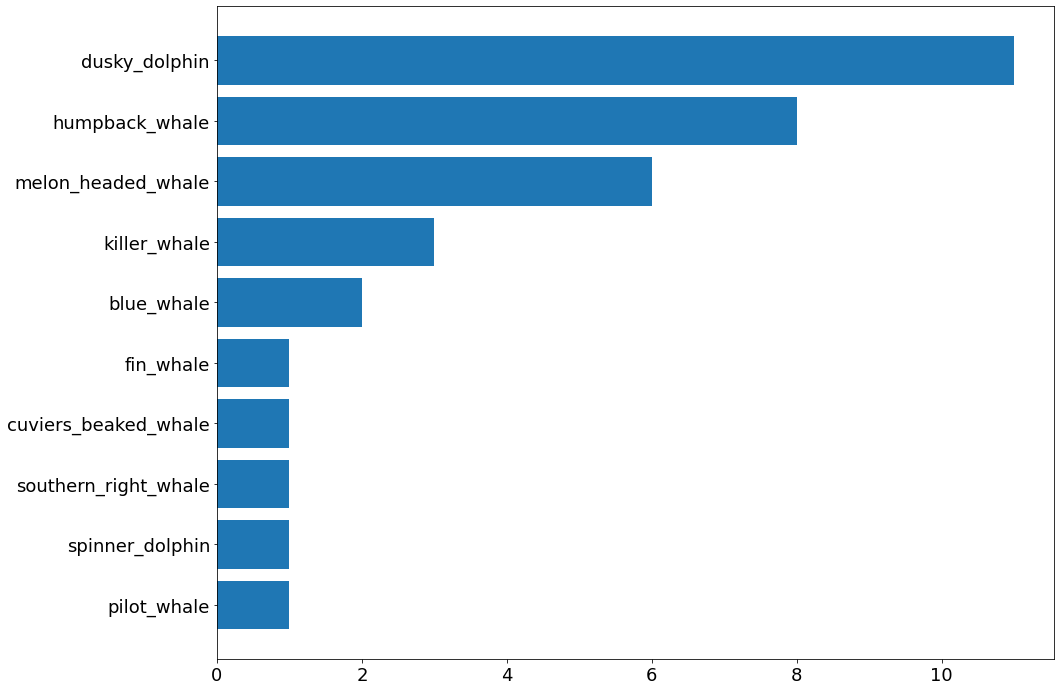

In [8]:
plt.figure(figsize=(15, 12))
plt.rcParams["font.size"] = 18
plt.barh(val_df["species"].value_counts().sort_values(ascending=True).index,
         val_df["species"].value_counts().sort_values(ascending=True),
         tick_label = val_df["species"].value_counts().sort_values(ascending=True).index)
plt.show()

### Chart of Whale vs Dolphin

In [9]:
val_df['label'] = val_df.species.map(lambda x: 'whale' if 'whale' in x else 'dolphin')

In [10]:
data = val_df['label'].value_counts().reset_index()
fig = px.bar(data, x='index', y='label', color='index', title='Whale Vs Dolphin')
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

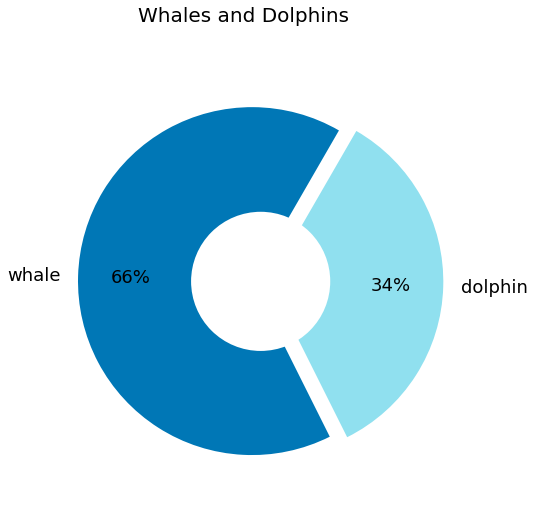

In [11]:
fig, ax  = plt.subplots(figsize=(16, 8))
fig.suptitle('Whales and Dolphins ', size = 20)
explode = (0.05, 0.05)
labels = list(val_df.label.value_counts().index)
sizes = val_df.label.value_counts().values
ax.pie(sizes, explode=explode,startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.7, colors=["#0077b6","#90e0ef"])
ax.add_artist(plt.Circle((0,0),0.4,fc='white'))
plt.show()

### Displaying the individual_id Present in the Dataset

In [12]:
val_df['individual_id'].value_counts()

c5940154ce98    1
8ba0cb9fe7e4    1
76f624409d6e    1
9903f4013331    1
66ad55d076b7    1
ed840f396590    1
91071a458934    1
b5b8f3e42c22    1
feb8cee2c2a2    1
637dd5599dae    1
f30e4a69dff7    1
1f53ac23232a    1
e8346f26f798    1
3d942ef38c97    1
902867f1f878    1
f7758fdeac94    1
016d51a4260b    1
8beb43dfa67e    1
482247439879    1
4bef98a6fa1e    1
f0795c89a15c    1
ac28317ce07c    1
9fda5cdd0f98    1
ee938ca54cb3    1
234972913c23    1
eb3271cc9351    1
a138bf337c8c    1
81787a3d0054    1
16892accd2d3    1
ac6c31d5838c    1
c5276108bab5    1
79ba9c59cd89    1
1ee45e8cf43c    1
d3aa8f0c55e9    1
cf109ad459ba    1
Name: individual_id, dtype: int64

### Displaying Images Randomly By Species

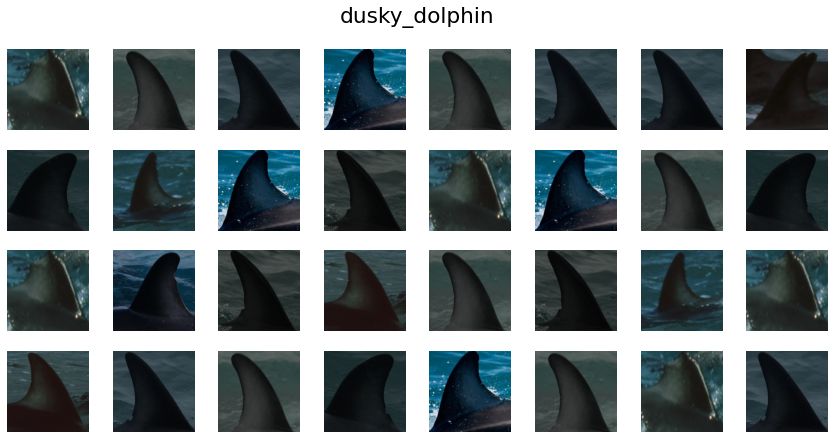

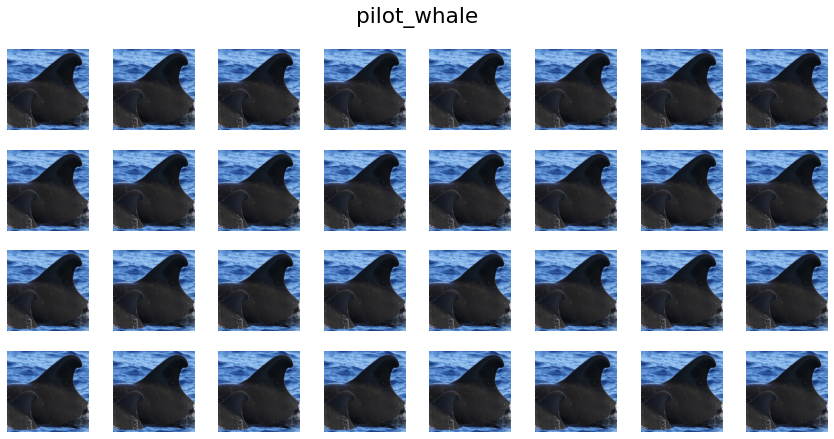

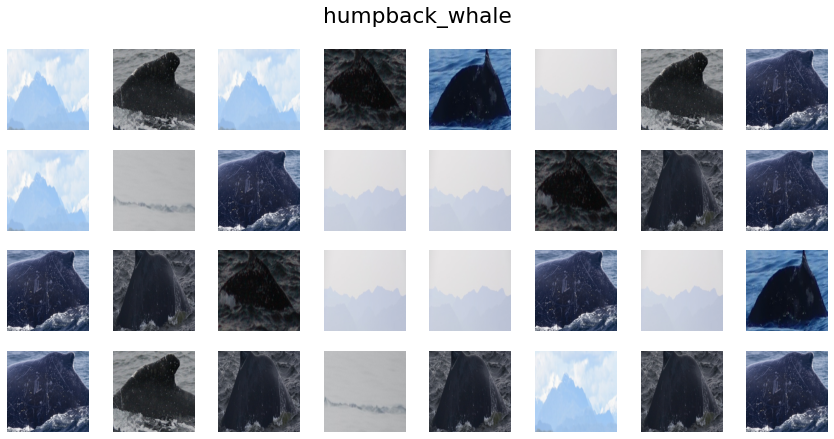

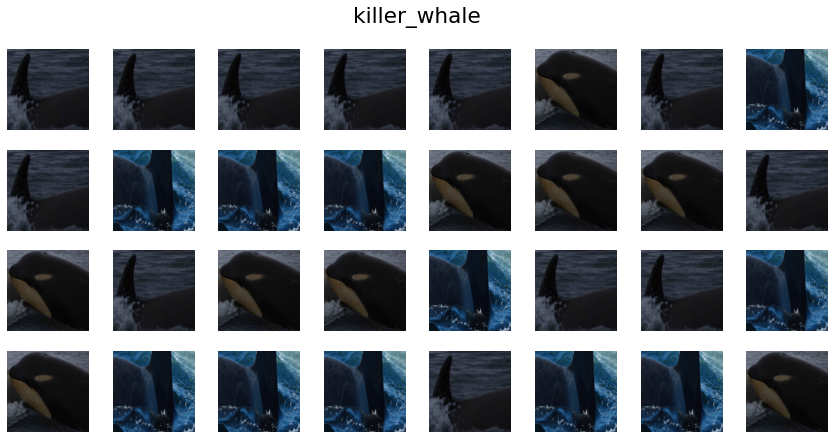

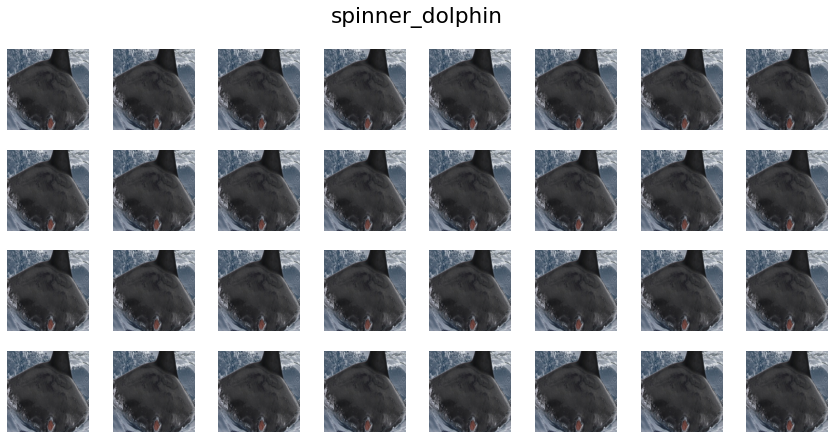

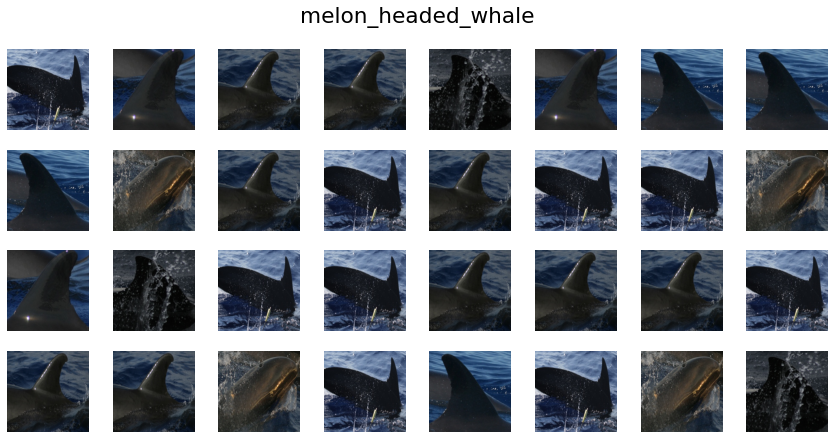

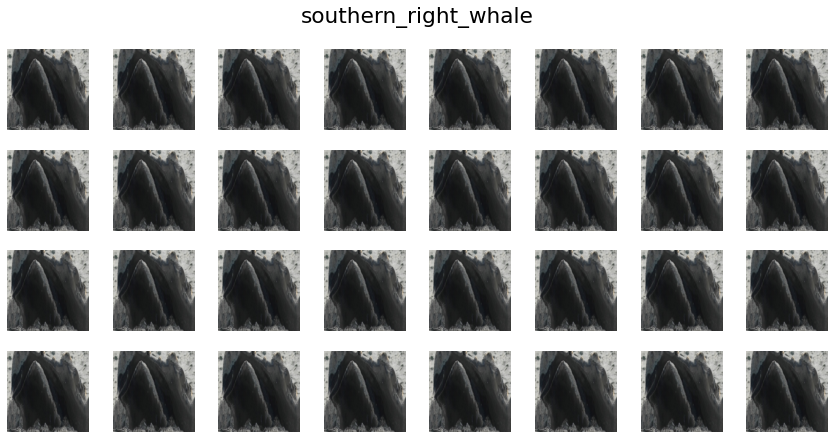

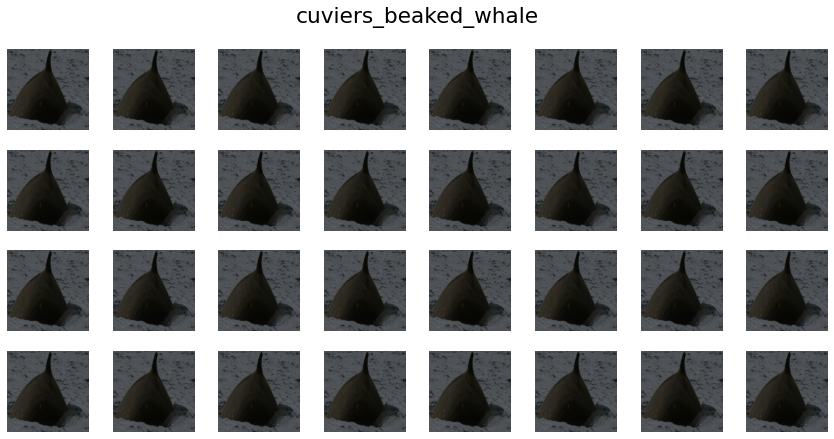

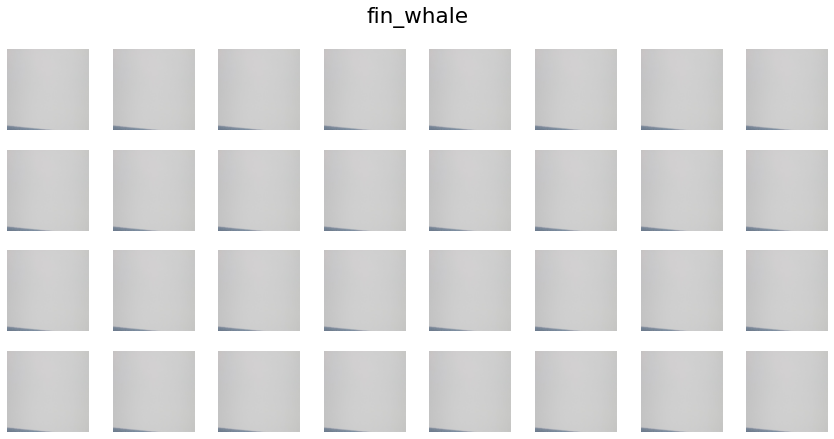

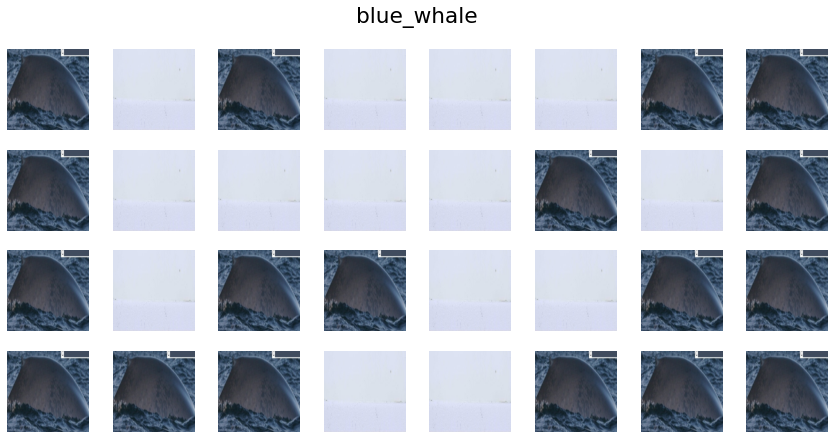

In [13]:
def plot_species(df, species):
    plt.figure(figsize = (12,12))
    species_df = df[df['species'] == species].reset_index(drop = True)
    plt.suptitle(species)
    for idx,i in enumerate(np.random.choice(path_trainimages + species_df['image'],32)):
        plt.subplot(8,8,idx+1)
        image_path = i
        img = Image.open(image_path)
        img = img.resize((224,224))
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


for species in val_df['species'].unique():
    plot_species(val_df , species)